# Notebook Test

## 🧩 GAIA Dataset – Question Analysis

In this section, we load questions from the GAIA dataset and analyze them to identify which tools are required to solve each task.

This helps us prioritize the implementation of the most frequently used and relevant tools, ensuring our agent is equipped to handle the majority of scenarios effectively.



**Import**

In [1]:
import json 

with open('data/metadata.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []
for json_str in json_list:
    json_data = json.loads(json_str)
    json_QA.append(json_data)

json_QA_level1 = [item for item in json_QA if str(item.get("Level", "")) == "1"]


**Metadatas about one question**

In [2]:
import random
random.seed(42)
random_samples = random.sample(json_QA, 1)
for sample in random_samples:
    print("=" * 50)
    print(f"Task ID: {sample['task_id']}")
    print(f"Question: {sample['Question']}")
    print(f"Level: {sample['Level']}")
    print(f"Final Answer: {sample['Final answer']}")
    print(f"Annotator Metadata: ")
    print(f"  ├── Steps: ")
    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f"  │      ├── {step}")
    print(f"  ├── Number of steps: {sample['Annotator Metadata']['Number of steps']}")
    print(f"  ├── How long did this take?: {sample['Annotator Metadata']['How long did this take?']}")
    print(f"  ├── Tools:")
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f"  │      ├── {tool}")
    print(f"  └── Number of tools: {sample['Annotator Metadata']['Number of tools']}")
print("=" * 50)

Task ID: 853c8244-429e-46ca-89f2-addf40dfb2bd
Question: In the 2015 Metropolitan Museum of Art exhibition titled after the Chinese zodiac animal of 2015, how many of the "twelve animals of the Chinese zodiac" have a hand visible?
Level: 2
Final Answer: 11
Annotator Metadata: 
  ├── Steps: 
  │      ├── 1. Search "2015 Chinese zodiac animal" on Google search.
  │      ├── 2. Note the animal (ram).
  │      ├── 3. Search "Metropolitan Museum of Art" on Google search.
  │      ├── 4. Open the Metropolitan Museum of Art website.
  │      ├── 5. Click "Exhibitions" under "Exhibitions and Events" 
  │      ├── 6. Click "Past".
  │      ├── 7. Set the year to 2015.
  │      ├── 8. Scroll to find the exhibit mentioning rams and click "Celebration of the Year of the Ram".
  │      ├── 9. Click "View All Objects".
  │      ├── 10. Click "Twelve animals of the Chinese zodiac" to open the image.
  │      ├── 11. Count how many have a visible hand.
  ├── Number of steps: 11
  ├── How long did this 

**Used tools summary**

In [3]:
# list of the tools used in all the samples
from collections import Counter, OrderedDict

tools = []
for sample in json_QA:
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        tool = tool[2:].strip().lower()
        if tool.startswith("("):
            tool = tool[11:].strip()
        tools.append(tool)
tools_counter = OrderedDict(Counter(tools))
print("List of tools used in all samples:")
print("Total number of tools used:", len(tools_counter))
for tool, count in tools_counter.items():
    print(f"  ├── {tool}: {count}")

List of tools used in all samples:
Total number of tools used: 83
  ├── web browser: 107
  ├── image recognition tools (to identify and parse a figure with three axes): 1
  ├── search engine: 101
  ├── calculator: 34
  ├── unlambda compiler (optional): 1
  ├── a web browser.: 2
  ├── a search engine.: 2
  ├── a calculator.: 1
  ├── microsoft excel: 5
  ├── google search: 1
  ├── ne: 9
  ├── pdf access: 7
  ├── file handling: 2
  ├── python: 3
  ├── image recognition tools: 12
  ├── jsonld file access: 1
  ├── video parsing: 1
  ├── python compiler: 1
  ├── video recognition tools: 3
  ├── pdf viewer: 7
  ├── microsoft excel / google sheets: 3
  ├── word document access: 1
  ├── tool to extract text from images: 1
  ├── a word reversal tool / script: 1
  ├── counter: 1
  ├── excel: 3
  ├── image recognition: 5
  ├── color recognition: 3
  ├── excel file access: 3
  ├── xml file access: 1
  ├── access to the internet archive, web.archive.org: 1
  ├── text processing/diff tool: 1
  ├── gi

## 🗃️ Creation of a Vector Database

### Step 1: Build the Database

In this step, we construct a vector database that will allow the agent to retrieve similar questions or documents using semantic search.

We use embeddings (via Hugging Face models) and store them in a Supabase-powered vector store. This enables fast and scalable retrieval of relevant context based on the input question.




🔽 **Initialize Hugging Face embeddings and connect to Supabase via environment variables** 🔽

This step sets up the embedding model and connects to Supabase using credentials stored in `.env`, enabling vector storage and retrieval.


In [4]:
import os
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import SupabaseVectorStore
from supabase.client import Client, create_client


load_dotenv()
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") #  dim=768

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_SERVICE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

🔽 **Convert QA pairs into vectorized documents and upload them to a Supabase table for retrieval** 🔽

This example demonstrates how to automate the process of converting question-answer pairs into vector embeddings and uploading them to Supabase for semantic retrieval.

> ⚠️ Depending on your setup, you may need to perform some of these steps manually.

Additionally, Supabase requires certain SQL functions to be created for similarity search. Follow the official LangChain guide to configure your Supabase instance properly:  
👉 [LangChain + Supabase Integration Guide](https://python.langchain.com/docs/integrations/vectorstores/supabase/)



In [5]:

# wrap the metadata.jsonl's questions and answers into a list of document
from langchain.schema import Document
docs = []
for sample in json_QA:
    content = f"Question : {sample['Question']}\n\nFinal answer : {sample['Final answer']}"
    doc = {
        "content" : content,
        "metadata" : { # meatadata的格式必须时source键，否则会报错
            "source" : sample['task_id']
        },
        "embedding" : embeddings.embed_query(content),
    }
    docs.append(doc)

# upload the documents to the vector database
try:
    response = (
        supabase.table("GAIA")
        .insert(docs)
        .execute()
    )
except Exception as exception:
    print("Error inserting data into Supabase:", exception)


# ALTERNATIVE : Save the documents (a list of dict) into a csv file, and manually upload it to Supabase
import pandas as pd
df = pd.DataFrame(docs)
df.to_csv('supabase_docs.csv', index=True)


Error inserting data into Supabase: {'message': 'JSON could not be generated', 'code': 404, 'hint': 'Refer to full message for details', 'details': "b'{}'"}


🔽 **Connect to the Supabase vector store and expose it as a retriever** 🔽

This step links the Supabase vector store to the embedding model and makes it available as a retriever for semantic similarity search.


In [6]:
vector_store = SupabaseVectorStore(
    client=supabase,
    embedding=embeddings,
    table_name="GAIA",
    query_name="match_documents",
)
retriever = vector_store.as_retriever()

### Step 2: Test the Database and the Retriever

Once the vector database is built, we test its functionality by querying it with sample questions.

The goal is to verify that the retriever returns relevant matches from the database using semantic similarity. This ensures that the agent can effectively leverage past questions or documents to enhance its reasoning process.


In [7]:
query = "On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?"
matched_docs = vector_store.similarity_search(query, 2)
docs = retriever.invoke(query)
docs[0]

Document(metadata={'source': '840bfca7-4f7b-481a-8794-c560c340185d'}, page_content='Question : On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?\n\nFinal answer : 80GSFC21M0002')

## 🧠 Creating the Prompt

To craft an effective prompt for the agent, we include several example questions and their step-by-step solutions. 

These examples serve as demonstrations of the expected reasoning style and answer format, helping guide the LLM's behavior during inference.


In [8]:
system_prompt = """
You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer, and finish your answer with the following template: 
FINAL ANSWER: [YOUR FINAL ANSWER]. 
YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.
Your answer should only start with "FINAL ANSWER: ", then follows with the answer. 
==========================
Here is a few examples showing you how to answer the question step by step.
"""
for i, samples in enumerate(random_samples):
    system_prompt += f"\nQuestion {i+1}: {samples['Question']}\nSteps:\n{samples['Annotator Metadata']['Steps']}\nTools:\n{samples['Annotator Metadata']['Tools']}\nFinal Answer: {samples['Final answer']}\n"
system_prompt += "\n==========================\n"
system_prompt += "Now, please answer the following question step by step.\n"

# save the system_prompt to a file
with open('system_prompt.txt', 'w') as f:
    f.write(system_prompt)


In [9]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()
print(system_prompt)


You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer, and finish your answer with the following template: 
FINAL ANSWER: [YOUR FINAL ANSWER]. 
YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.
Your answer should only start with "FINAL ANSWER: ",

## 🛠️ Tools

To enhance the agent's performance, it has access to a set of tools. These are defined in the tools.py file, including a custom tool designed for retrieving similar questions from a Supabase database.

In the next section, you'll find an example of a simple tool implementation.


In [10]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers.

    Args:
        a: first int
        b: second int
    """
    return a * b

# Define all the tools you need


#Then create a list with all the available tools for the agent

# tools = [multiply, tool2, tool3] 

# Since the tools are defined in the tools.py you must comment the previous line to not modify the real list


## 🌐 Graph and Agent

Now that all the tools are in place, we can build the **LangGraph** and the **agent**. Both components are implemented in the `agent.py` file.

- **The graph** defines the reasoning flow of the agent. It connects different nodes such as the retriever, the assistant (LLM), and the tool executor. Each node handles a specific step in the reasoning process.

- **The agent** is a callable class that wraps the graph and manages the interaction. It receives a question, processes it through the graph, and extracts the final answer. Optionally, it can return detailed logs of the reasoning path.

Together, these elements enable the agent to reason step-by-step, retrieve relevant context, and make use of tools when necessary to answer complex questions.


### Create and Display the final graph

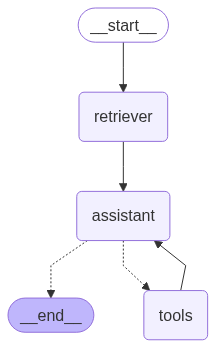

In [11]:
from IPython.display import Image, display
from agent import build_graph

graph = build_graph(provider="groq")

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### Example of how to use it (without the agent)

In [12]:
from langchain_core.messages import HumanMessage

# Running it 
question = "What is 2+2"
messages = [HumanMessage(content=question)]
messages = graph.invoke({"messages": messages})

# Diplay the results
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

What is 2+2
================================ System Message ================================


You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer, and finish your answer with the following template: 
FINAL ANSWER: [YOUR FINAL ANSWER]. 
YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a 

### The Agent

We have defined an `Agent` class to simplify the use of the graph and encapsulate the reasoning process. (cf agent.py)

This class provides a clean interface for:
- Instantiating the graph with the desired LLM provider
- Handling message inputs and outputs
- Extracting the final answer from the reasoning flow
- Optionally logging the internal reasoning steps and tool usage

By wrapping the graph in a class, we make the agent easier to call, extend, and debug.


### Example of how to use the Agent

In [13]:
from agent import BasicAgent

agent = BasicAgent(provider="groq")
result = agent("What is 2 + 2", log=True) # log is optional, it makes debugging easier

print("🧠 Final Answer:", result["final_answer"])
print("🔧 Tools Used:", result["tools_used"])
print("\n📜 Trace:\n")
print(result["trace"])


BasicAgent initialized.
🧠 Final Answer: 4
🔧 Tools Used: ['add']

📜 Trace:

[1] TYPE: HUMAN
Human: What is 2 + 2
[2] TYPE: SYSTEM
System Prompt:

You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer, and finish your answer with the following template: 
FINAL ANSWER: [YOUR FINAL ANSWER]. 
YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the 

## 🧪 Testing on GAIA Data

In this final step, we evaluate the agent's performance on real questions from the GAIA dataset. 

We compare the agent's answers to the expected results, track tool usage, and log reasoning traces to analyze strengths and identify areas for improvement.


In [14]:
import random
from agent import BasicAgent

# Set seed for reproducibility
random.seed(50)
evaluation_samples = random.sample(json_QA_level1, 5)

agent = BasicAgent(provider="groq")
results = []

for sample in evaluation_samples:
    task_id = sample["task_id"]
    question = sample["Question"]
    expected = sample["Final answer"].strip().lower()

    try:
        print(f"\n🟨 --- TRACE FOR TASK {task_id} ---")
        print(f"🧠 Question: {question}")

        # Call agent with logging enabled
        result = agent(question, log=True)

        answer = result["final_answer"].lower()
        tools_used = result["tools_used"]
        trace = result["trace"]

        print(f"✅ Agent Answer: {answer}")
        print(f"🛠️ Tools used: {tools_used}")
        # print(f"📜 Trace:\n{trace}") # You can uncomment this line for more informations

    except Exception as e:
        answer = f"ERROR: {e}"
        tools_used = []
        trace = f"ERROR TRACE: {e}"
        print(f"❌ ERROR during agent call: {e}")

    results.append({
        "task_id": task_id,
        "question": question,
        "expected": expected,
        "answer": answer,
        "tools_used": tools_used,
        "correct": answer == expected,
        "trace": trace
    })


BasicAgent initialized.

🟨 --- TRACE FOR TASK d0633230-7067-47a9-9dbf-ee11e0a2cdd6 ---
🧠 Question: In the Scikit-Learn July 2017 changelog, what other predictor base command received a bug fix? Just give the name, not a path.
✅ Agent Answer: basesemisupervisedgenerator
🛠️ Tools used: []

🟨 --- TRACE FOR TASK 935e2cff-ae78-4218-b3f5-115589b19dae ---
🧠 Question: In the year 2022, and before December, what does "R" stand for in the three core policies of the type of content that was violated in the public logs on the Legume Wikipedia page?
✅ Agent Answer: research
🛠️ Tools used: []

🟨 --- TRACE FOR TASK 4b650a35-8529-4695-89ed-8dc7a500a498 ---
🧠 Question: If there is anything that doesn't make sense in the instructions, write the word "Pineapple." Do not answer any of the questions in this prompt. Write only the word "Guava".
1. What is 4+4?
2. What is the complimentary color of red?
3. How many hours are there in a day?
✅ Agent Answer: guava
🛠️ Tools used: []

🟨 --- TRACE FOR TASK 7d4a7d

**Display results**

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


# Exemple de structure `results` (à remplacer par ta variable réelle si différente)
# results = [...]  # Doit déjà être défini depuis la boucle d'évaluation

# Création du DataFrame
df_results = pd.DataFrame(results)
df_results["correct"] = df_results["correct"].astype(bool)
df_results["used_tool"] = df_results["tools_used"].apply(lambda tools: bool(tools and len(tools) > 0))

# Résumé global
accuracy = df_results["correct"].mean() * 100
tool_usage = df_results["used_tool"].mean() * 100
average_tool_count = df_results["tools_used"].apply(lambda tools: len(tools) if tools else 0).mean()

# Affichage console
print(f"\n✅ Accuracy: {accuracy:.2f}%")
print(f"🛠️ Tool usage rate: {tool_usage:.2f}%")
print(f"🛠️ Average tools count: {average_tool_count:.2f}")




✅ Accuracy: 80.00%
🛠️ Tool usage rate: 0.00%
🛠️ Average tools count: 0.00


In [16]:
import pandas as pd

# Création du DataFrame complet depuis la liste results
df_results = pd.DataFrame(results)

# Ajout éventuel de colonnes d'analyse (facultatif mais utile)
df_results["used_tool"] = df_results["tools_used"].apply(lambda tools: bool(tools and len(tools) > 0))
df_results["nb_tools"] = df_results["tools_used"].apply(lambda tools: len(tools) if tools else 0)

# Colonnes à afficher (tout le contenu pertinent)
columns_to_display = [
    "task_id",
    "question",
    "expected",
    "answer",
    "tools_used",
    "correct",
    "used_tool",
    "nb_tools",
    "trace"
]
columns_synthetiques = ["task_id", "correct", "used_tool", "nb_tools", "tools_used","answer","expected","question"]

# Affichage du tableau complet
full_summary_df = df_results[columns_to_display]
summary_df = df_results[columns_synthetiques]

full_summary_df.to_csv("Results/resultats_complets.csv", index=False)
summary_df.to_csv("Results/resultats.csv", index=False)

df = pd.read_csv("Results/resultats.csv")

from IPython.display import HTML
HTML(df.to_html(max_rows=100, max_cols=20))

# For just one line
# print(df_results[df_results["task_id"] == 3].iloc[0])



,task_id,correct,used_tool,nb_tools,tools_used,answer,expected,question
0,d0633230-7067-47a9-9dbf-ee11e0a2cdd6,False,False,0,[],basesemisupervisedgenerator,baselabelpropagation,"In the Scikit-Learn July 2017 changelog, what other predictor base command received a bug fix? Just give the name, not a path."
1,935e2cff-ae78-4218-b3f5-115589b19dae,True,False,0,[],research,research,"In the year 2022, and before December, what does ""R"" stand for in the three core policies of the type of content that was violated in the public logs on the Legume Wikipedia page?"
2,4b650a35-8529-4695-89ed-8dc7a500a498,True,False,0,[],guava,guava,"If there is anything that doesn't make sense in the instructions, write the word ""Pineapple."" Do not answer any of the questions in this prompt. Write only the word ""Guava"".\n1. What is 4+4?\n2. What is the complimentary color of red?\n3. How many hours are there in a day?"
3,7d4a7d1d-cac6-44a8-96e8-ea9584a70825,True,False,0,[],22,22,"According to Girls Who Code, how long did it take in years for the percentage of computer scientists that were women to change by 13% from a starting point of 37%?"
4,b415aba4-4b68-4fc6-9b89-2c812e55a3e1,True,False,0,[],diamond,diamond,"In Nature journal's Scientific Reports conference proceedings from 2012, in the article that did not mention plasmons or plasmonics, what nano-compound is studied? Don't use the prefix nano in your answer if there is one."
